In [1]:
import time

import IPython
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from scnn.losses import mse_loss
from scnn.sh import n_coeffs, spherical_harmonic
from scnn.sim import compartment_model_simulation
from scnn.models import SCNNModel

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    raise Exception("CUDA not available")

BATCH_SIZE = int(5e2)
N_BATCHES = int(1e5)
SNR = 30

NVIDIA RTX A1000 6GB Laptop GPU


In [2]:
# Acquisition protocol

bvals = torch.round(
    torch.tensor(np.loadtxt("../data/tensor-valued/lte-pte.bval") / 1e3),
    decimals=1,
).float()
bvecs = torch.tensor(np.loadtxt("../data/tensor-valued/lte-pte.bvec").T).float()

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = [0.5, 1, 2, 3.5, 5, 0.5, 1, 2]
n_shells = len(bs)
shell_indices = [
    torch.arange(0, 12),
    torch.arange(12, 24),
    torch.arange(24, 44),
    torch.arange(44, 64),
    torch.arange(64, 94),
    torch.arange(94, 106),
    torch.arange(106, 118),
    torch.arange(118, 138),
]
shell_l_maxs = [
    2,
    2,
    4,
    4,
    6,
    2,
    2,
    4,
]

bvecs_isft_per_shell = []
bvecs_sft_per_shell = []
for idx, l_max in zip(shell_indices, shell_l_maxs):
    shell_bvecs = bvecs[idx]
    thetas = torch.arccos(shell_bvecs[:, 2])
    phis = (torch.arctan2(shell_bvecs[:, 1], shell_bvecs[:, 0]) + 2 * np.pi) % (
        2 * np.pi
    )
    bvecs_isft = torch.zeros(len(shell_bvecs), 45)
    for l in range(0, l_max + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = spherical_harmonic(
                l, m, thetas, phis
            )
    bvecs_isft_per_shell.append(bvecs_isft)
    bvecs_sft = torch.zeros((45, len(shell_bvecs)), dtype=float)
    bvecs_sft[0:45] = (
        torch.linalg.pinv(bvecs_isft[:, 0:45].T @ bvecs_isft[:, 0:45])
        @ bvecs_isft[:, 0:45].T
    )
    bvecs_sft_per_shell.append(bvecs_sft.float())

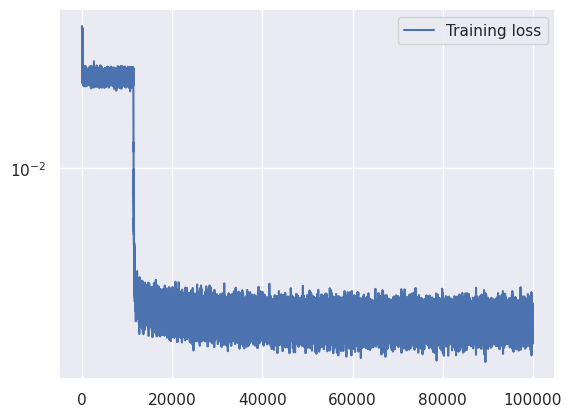

Training lasted 783 min


In [3]:
# Train with rotations

Rs = torch.tensor(
    np.concatenate(
        (
            np.eye(45)[np.newaxis],
            np.load("../Rs.npy").reshape(-1, 45, 45),
        ),
        axis=0,
    )
).float()

model = SCNNModel(8, 4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

training_odfs_sh = torch.load("../data/odfs/training_odfs_sh.pt")

training_losses = []
validation_losses = []

start_time = time.time()

for batch in range(1, N_BATCHES + 1):
    if batch == int(0.5 * N_BATCHES) or batch == int(0.75 * N_BATCHES):
        scheduler.step()

    torch.random.manual_seed(batch)
    batch_ds_1 = torch.rand(BATCH_SIZE) * 3
    batch_ds_2 = torch.rand(BATCH_SIZE) * batch_ds_1.clip(0, 0.5)
    batch_fs_1 = torch.rand(BATCH_SIZE)
    batch_fs_2 = torch.rand(BATCH_SIZE) * (1 - batch_fs_1)

    np.random.seed(batch)
    batch_odfs_sh = (
        Rs[np.random.choice(len(Rs), BATCH_SIZE)]
        @ training_odfs_sh[
            np.random.choice(len(training_odfs_sh), BATCH_SIZE)
        ].unsqueeze(-1)
    ).squeeze(-1)

    batch_targets = torch.hstack(
        (
            batch_odfs_sh,
            batch_ds_1.unsqueeze(1),
            batch_ds_2.unsqueeze(1),
            batch_fs_1.unsqueeze(1),
            batch_fs_2.unsqueeze(1),
        )
    )

    batch_ads = torch.vstack(
        (
            batch_ds_1,
            batch_ds_2,
            batch_ds_1
            * (1 - batch_fs_1 - batch_fs_2)
            ** (0.5 * batch_fs_2 / (batch_fs_2 + batch_fs_1)),
        )
    ).T
    batch_rds = torch.vstack(
        (
            torch.zeros(BATCH_SIZE),
            batch_ds_2,
            batch_ds_1
            * (1 - batch_fs_1 - batch_fs_2)
            ** ((0.5 * batch_fs_2 + batch_fs_1) / (batch_fs_2 + batch_fs_1)),
        )
    ).T
    batch_fs = torch.vstack(
        (
            batch_fs_1,
            batch_fs_2,
            1 - batch_fs_1 - batch_fs_2,
        )
    ).T

    batch_signals = torch.zeros(BATCH_SIZE, len(bvals))
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_per_shell[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        batch_signals[:, shell_indices[j]] = shell_signals.squeeze(-1).float()

    batch_signals_sh = torch.zeros(BATCH_SIZE, n_shells, 45)
    for i, idx in enumerate(shell_indices):
        batch_signals_sh[:, i] = (
            bvecs_sft_per_shell[i] @ batch_signals[:, idx].unsqueeze(-1)
        ).squeeze(-1)

    y = model(torch.nn.functional.pad(batch_signals_sh, (0, n_coeffs - 45)).to(device))
    loss = mse_loss(y, batch_targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    training_losses.append(loss.item())
    print(f"batch {batch}, loss = {loss.item()}", end="\r")

    if batch % 1000 == 0 or batch == N_BATCHES:
        IPython.display.clear_output(wait=True)
        plt.plot(training_losses)
        plt.legend(["Training loss"])
        plt.yscale("log")
        plt.show()

print(f"Training lasted {int((time.time() - start_time) / 60)} min")
torch.save(model.state_dict(), "../scnn_weights_rot_neural_soma.pt")